In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
#from helper_functions.invertible_neural_network_positive import InvertibleNetworkSurrogate

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, mean_absolute_percentage_error

import PyMieScatt as pms

In [2]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dlogD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log10(GSD)))) * np.exp(-(np.log10(D_array)-np.log10(D_median))**2/(2*(np.log10(GSD)**2)))   # cm-3
    return n

def lognormal_fit(PSD, diameters, init_guess, fit_bounds):
    #fit_bounds=([0,0,2,0,0,3],[np.inf,1.25,5,np.inf,1.25,10])
    pu, pcovu = curve_fit(lognormal, diameters, PSD, p0=init_guess, bounds=fit_bounds, max_nfev=1e4)
    return(pu, pcovu)

def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

def read_results(qoi, var='F11'):
    F11 = [x for x in qoi.index if var in x]
    index_list = [int(x[10:]) for x in F11]
    values = qoi[F11].values
    output = pd.DataFrame(index=index_list, columns=[var])
    output[var] = values
    return output

def run_pymiescatt(R_median, GSD, N_tot, ri_n, ri_k, wvl, angles, D_array):
    '''
    R_median in um (NOTE: this is the median radius of the NUMBER size distribution!)
    N_tot in cm-3
    ri_k as positive float number
    wvl in um
    angles is the array of angles
    D_array is the diameter array in nm
    '''
    lambd = wvl *1e3   # from um to nm
    m = ri_n + 1j * ri_k
    mu = np.cos(angles * np.pi / 180)
    
    n = lognormal(D_array, R_median*2 * 1e3, GSD, N_tot)/D_array / 2.303
    
    cscat = []
    for d in D_array:
            cscat_temp = pms.MieQ(m, lambd, d, asCrossSection=True)[1]
            cscat.append(cscat_temp)
    
    S11 = []
    S11_test = []
    S12 = []
    for diam in D_array:
        x = diam * np.pi / lambd
        theta, SL, SR, S11_temp = pms.ScatteringFunction(m, lambd, diam,
                                                        minAngle=angles.min(), maxAngle=angles.max(),
                                                        angularResolution=angles[1]-angles[0],
                                                        normalization=None)
        S11_test.append(S11_temp)
        # S11.append(S11_temp / np.trapz(S11_temp, x=np.flip(mu)) / (2*np.pi))
        qscat_temp = pms.MieQ(m, lambd, diam, asCrossSection=False)[1]
        S11.append(S11_temp / (qscat_temp * x**2 * np.pi))
        
        # S12.append( (0.5*(SR-SL)) / np.trapz(S11_temp, x=np.flip(mu)) / (2*np.pi))
        S12.append( (0.5*(SR-SL)) / (qscat_temp * x**2 * np.pi))
    S11 = np.array(S11).T
    # S11_test = np.array(S11_test).T
    S12 = np.array(S12).T            
         
    F11 = np.trapz(S11 * n * cscat * 1e-6, x=D_array)
    # F11_test = np.trapz(S11_test * n * (lambd / 4 / np.pi)**2 * 1e-6, x=D_array)
    F12 = np.trapz(S12 * n * cscat * 1e-6, x=D_array)
    PPF = - F12 / F11 
    
    pymiescatt = pd.DataFrame(index=angles, columns=['F11', 'F12', 'PPF'])
    pymiescatt['F11'] = F11
    # pymiescatt['F11_test'] = F11_test
    pymiescatt['F12'] = F12
    pymiescatt['PPF'] = PPF
    
    return pymiescatt

### Load measurements

In [3]:
datafile= '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'

uneph_qoi_plot = pd.read_hdf(datafile,'qoi')
uneph_dvar_plot = pd.read_hdf(datafile,'param')

uneph_qoi_plot = uneph_qoi_plot.astype(np.float64)
uneph_dvar_plot = uneph_dvar_plot.astype(np.float64)




In [4]:
meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
dvar_meas_preprocessed_plot = pd.read_hdf(meas_datafile_preprocessed,'param')

qoi_meas_preprocessed_plot = pd.read_hdf(meas_datafile_preprocessed,'qoi')
qoi_meas_preprocessed_plot = qoi_meas_preprocessed_plot.astype(np.float64)
dvar_meas_preprocessed_plot = dvar_meas_preprocessed_plot.astype(np.float64)



In [5]:
# Remove the "_0.532" from the column names
uneph_qoi_plot.columns = uneph_qoi_plot.columns.str.replace(r'_0.532_', '_')
qoi_meas_preprocessed_plot.columns = qoi_meas_preprocessed_plot.columns.str.replace(r'_0.532_', '_')

<ipython-input-5-b45477438585>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  uneph_qoi_plot.columns = uneph_qoi_plot.columns.str.replace(r'_0.532_', '_')
<ipython-input-5-b45477438585>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas_preprocessed_plot.columns = qoi_meas_preprocessed_plot.columns.str.replace(r'_0.532_', '_')


In [6]:
# Prepare data for input to the model --> np.log(F11 /4 /np.pi)

F11_list = [x for x in uneph_qoi_plot.columns if 'F11' in x]
PPF_list = [x for x in uneph_qoi_plot.columns if 'PPF' in x]

uneph_qoi = uneph_qoi_plot.copy()
uneph_qoi[F11_list] = np.log( uneph_qoi[F11_list] / 4 / np.pi )
uneph_qoi[PPF_list] = ( uneph_qoi[PPF_list] )


qoi_meas_preprocessed = qoi_meas_preprocessed_plot.copy()
qoi_meas_preprocessed[F11_list] = np.log(qoi_meas_preprocessed[F11_list] / 4/ np.pi)


### Load PyMieScatt simulations
F11 and PPF are calculated with PyMieScatt using as state parameters the values "dvar" stored in the uneph .h5 file

In [7]:
pms_qoi_plot = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5', key='qoi')


### Load the model to test

In [8]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

# Model directory
directory = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv5'

#'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv1'
model_dir = directory + '/models'

# Plot directory (subdirectory of the model)
#test_directory = '/data/project/general/aerosolretriev/aerosol_results_january_2023/results_Barbara/test_to_be_cancelled'
#plot_dir = test_directory +'/plots/model'
plot_dir = model_dir +'/plots/measurements_new'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [9]:
custom_objects = {'AdjustedRSquared':AdjustedRSquared}

kwargs = {'custom_objects':custom_objects, 'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

#### Inverse prediction 
From F11 and PPF to state parameters

In [10]:
start = time.time()
uneph_dvar_pred_iv_original = surr.sample_n_tries(uneph_qoi.values, batch_size=8, n_tries=32)
end = time.time()
dt = (end-start)#/len(dvar_test)

uneph_dvar_pred_iv = pd.DataFrame(data=uneph_dvar_pred_iv_original, columns=uneph_dvar_plot.columns)

print('Time for the inverse prediction: %i s' %dt)

Time for the inverse prediction: 3 s


In [11]:
start = time.time()
dvar_meas_preprocessed_pred = surr.sample_n_tries(qoi_meas_preprocessed.values, batch_size=8, n_tries=32)
end = time.time()
dt = (end-start)#/len(dvar_test)

dvar_meas_preprocessed_pred_iv = pd.DataFrame(data=dvar_meas_preprocessed_pred, columns=uneph_dvar_plot.columns)

print('Time for the inverse prediction: %i s' %dt)

Time for the inverse prediction: 2 s


In [12]:
uneph_dvar_pred_iv_plot = uneph_dvar_pred_iv.copy()
uneph_dvar_pred_iv_plot['Vtot'] = np.exp(uneph_dvar_pred_iv_plot['Vtot'])
uneph_dvar_pred_iv_plot['RmedianV'] = (np.exp(uneph_dvar_pred_iv_plot['RmedianV']) )*1e-3
uneph_dvar_pred_iv_plot['GSD'] = np.exp(uneph_dvar_pred_iv_plot['GSD'])+1
uneph_dvar_pred_iv_plot['n'] = np.exp(uneph_dvar_pred_iv_plot['n'])+1.33
uneph_dvar_pred_iv_plot['k'] = np.exp(uneph_dvar_pred_iv_plot['k'])

In [13]:
dvar_meas_preprocessed_pred_iv_plot = dvar_meas_preprocessed_pred_iv.copy()
dvar_meas_preprocessed_pred_iv_plot['Vtot'] = np.exp(dvar_meas_preprocessed_pred_iv_plot['Vtot'])
dvar_meas_preprocessed_pred_iv_plot['RmedianV'] = (np.exp(dvar_meas_preprocessed_pred_iv_plot['RmedianV']))*1e-3
dvar_meas_preprocessed_pred_iv_plot['GSD'] = np.exp(dvar_meas_preprocessed_pred_iv_plot['GSD'])+1
dvar_meas_preprocessed_pred_iv_plot['n'] = np.exp(dvar_meas_preprocessed_pred_iv_plot['n'])+1.33
dvar_meas_preprocessed_pred_iv_plot['k'] = np.exp(dvar_meas_preprocessed_pred_iv_plot['k'])



#### Forward prediction
From state parameters to F11 and PPF

In [14]:
start = time.time()
uneph_qoi_pred_fw_original = surr.predict(uneph_dvar_pred_iv.values)
end = time.time()
dt = (end-start)#/len(dvar_test)

uneph_qoi_pred_fw = pd.DataFrame(data=uneph_qoi_pred_fw_original, columns=uneph_qoi_plot.columns)

print('Time for the forward prediction: %i s' %dt)

Time for the forward prediction: 0 s


In [15]:
start = time.time()
qoi_meas_preprocessed_pred_fw_original = surr.predict(dvar_meas_preprocessed_pred_iv.values)
end = time.time()
dt = (end-start)#/len(dvar_test)

qoi_meas_preprocessed_pred_fw = pd.DataFrame(data=qoi_meas_preprocessed_pred_fw_original, columns=uneph_qoi_plot.columns)

print('Time for the forward prediction: %i s' %dt)

Time for the forward prediction: 0 s


In [16]:
# Process the data for the plots --> np.exp(F11)

uneph_qoi_pred_fw_plot = uneph_qoi_pred_fw.copy()
uneph_qoi_pred_fw_plot[F11_list] = np.exp(uneph_qoi_pred_fw_plot[F11_list])
uneph_qoi_pred_fw_plot[PPF_list] = (uneph_qoi_pred_fw_plot[PPF_list])

In [17]:
# Process the data for the plots --> np.exp(F11)

qoi_meas_preprocessed_pred_fw_plot = qoi_meas_preprocessed_pred_fw.copy()
qoi_meas_preprocessed_pred_fw_plot[F11_list] = np.exp(qoi_meas_preprocessed_pred_fw_plot[F11_list])
qoi_meas_preprocessed_pred_fw_plot[PPF_list] = (qoi_meas_preprocessed_pred_fw_plot[PPF_list])

### Calculate F11 and PPF using PyMieScatt and state parameters from INN

In [18]:
angles = np.arange(0,180,1)
D_array = np.logspace(0.1, 5, 300)
nstd = 10

pms_pred_qoi = pd.DataFrame(index=np.arange(0, 14), columns=np.arange(0, 360))

for idx, row in uneph_dvar_pred_iv_plot.iterrows():
    
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]

    pms_tmp = run_pymiescatt(DmedianN/2*1e-3, row['GSD'], Ntot, row['n'], row['k'], 0.532, angles, D_array)
    pms_pred_qoi.iloc[idx] = np.concatenate([pms_tmp['F11'].T.values, pms_tmp['PPF'].T.values])
   

In [19]:
angles = np.arange(0,180,1)
D_array = np.logspace(0.1, 5, 300)
nstd = 10

pms_pred_qoi_preprocessed = pd.DataFrame(index=np.arange(0, 14), columns=np.arange(0, 360))

for idx, row in dvar_meas_preprocessed_pred_iv_plot.iterrows():
    
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]

    pms_tmp1 = run_pymiescatt(DmedianN/2*1e-3, row['GSD'], Ntot, row['n'], row['k'], 0.532, angles, D_array)
    pms_pred_qoi_preprocessed.iloc[idx] = np.concatenate([pms_tmp1['F11'].T.values, pms_tmp1['PPF'].T.values])
   

### Measurements + PyMieScatt  + Model

In [19]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
theta = np.concatenate([angles1, angles2])

#### PSL

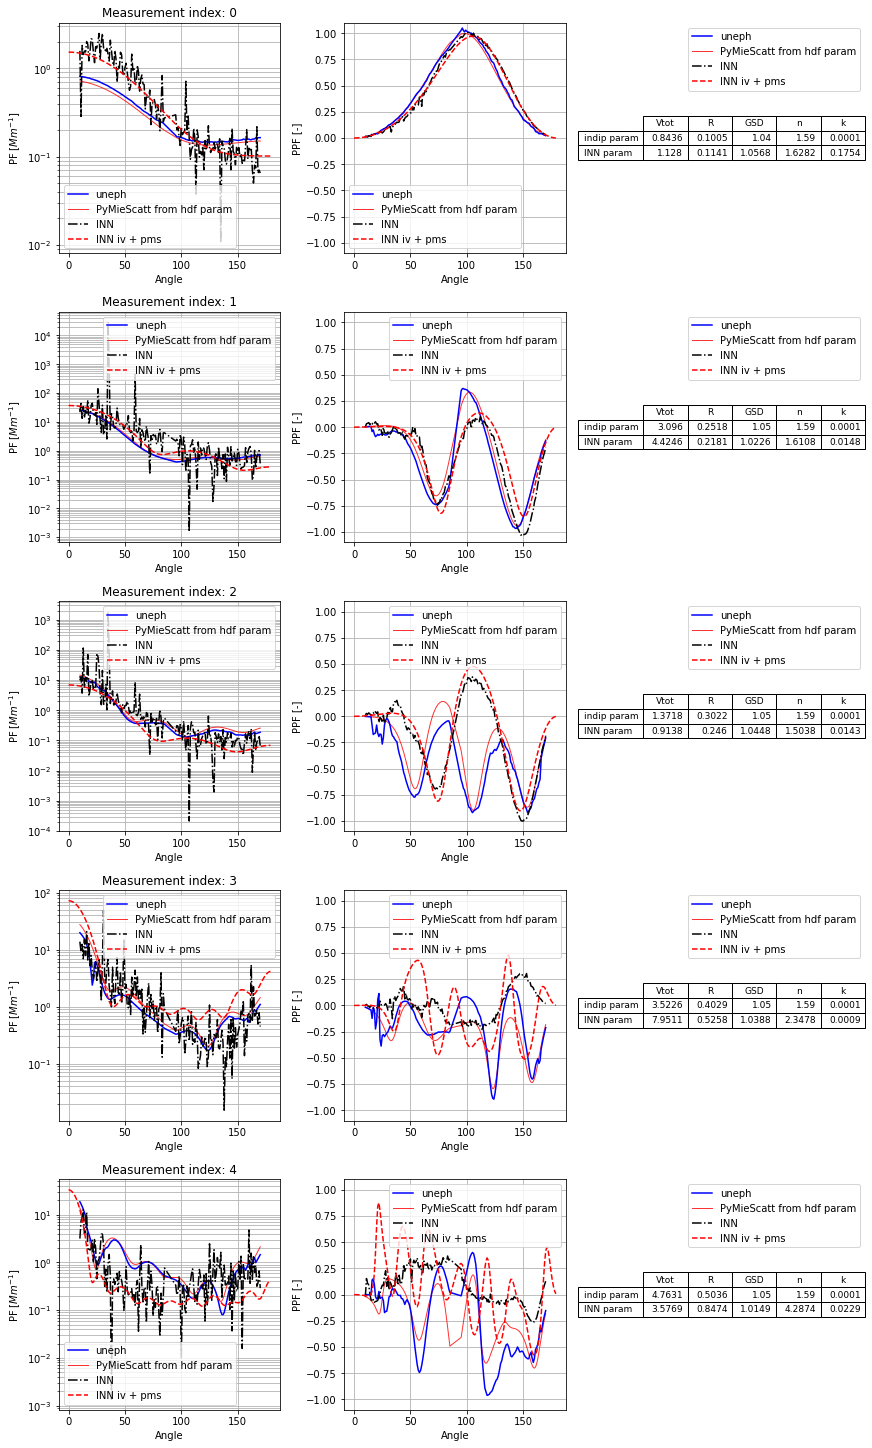

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12, 20), constrained_layout=True)

idx = 0

for index in np.arange(0, 5):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    meas_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')
    
    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot, pms_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
    
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_PSL.jpg')

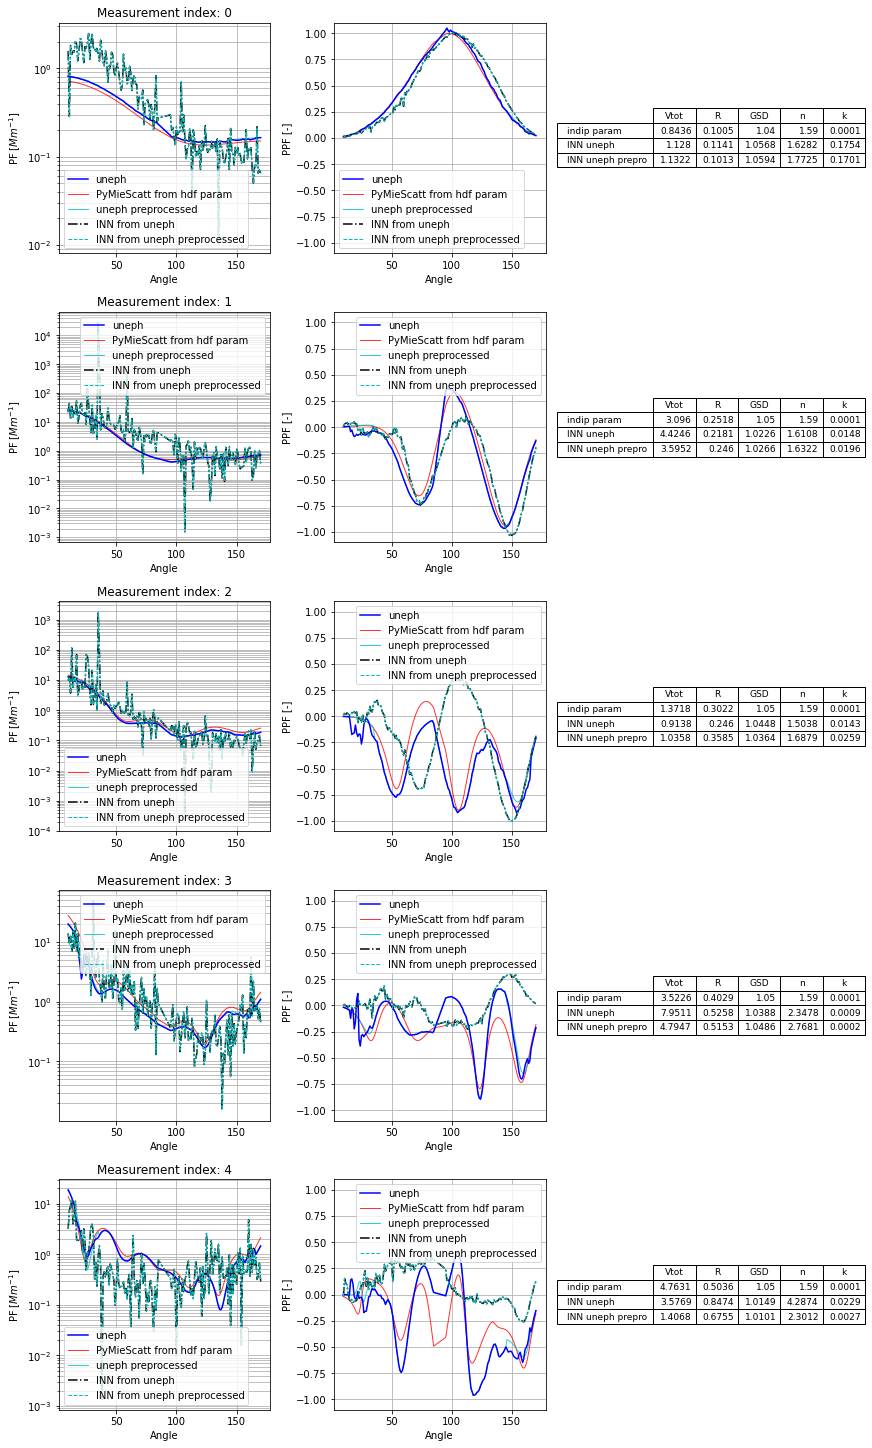

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12, 20), constrained_layout=True)

idx = 0

for index in np.arange(0, 5):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_prepro_plot, = axs[idx, 0].plot(theta, qoi_meas_preprocessed_plot[F11_list].loc[index]/4/np.pi, ls='-', lw='1', c='c', alpha=0.8, label='uneph preprocessed')
    meas_prepro_plot, = axs[idx, 1].plot(theta, qoi_meas_preprocessed_plot[PPF_list].loc[index], ls='-', lw='1', c='c', alpha=0.8, label='uneph preprocessed')
    
    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN from uneph')
    meas_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN from uneph')
    
   # pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
   # pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')
    
    meas_prepro_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls = '--',lw='1',c= 'c', label = 'INN from uneph preprocessed')
    meas_prepro_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls = '--',lw='1',c= 'c', label = 'INN from uneph preprocessed')
    
    
    
    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.grid(which='both')
    
  #  axs[idx,0].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, pms_pred_qoi_plot,meas_prepro_pred_plot])
  #  axs[idx,1].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, pms_pred_qoi_plot,meas_prepro_pred_plot])
    axs[idx,0].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, meas_prepro_pred_plot])
    axs[idx,1].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, meas_prepro_pred_plot])

    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model2_param = dvar_meas_preprocessed_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN uneph', 'INN uneph prepro']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param, model2_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_PSL_preprocessed.jpg')

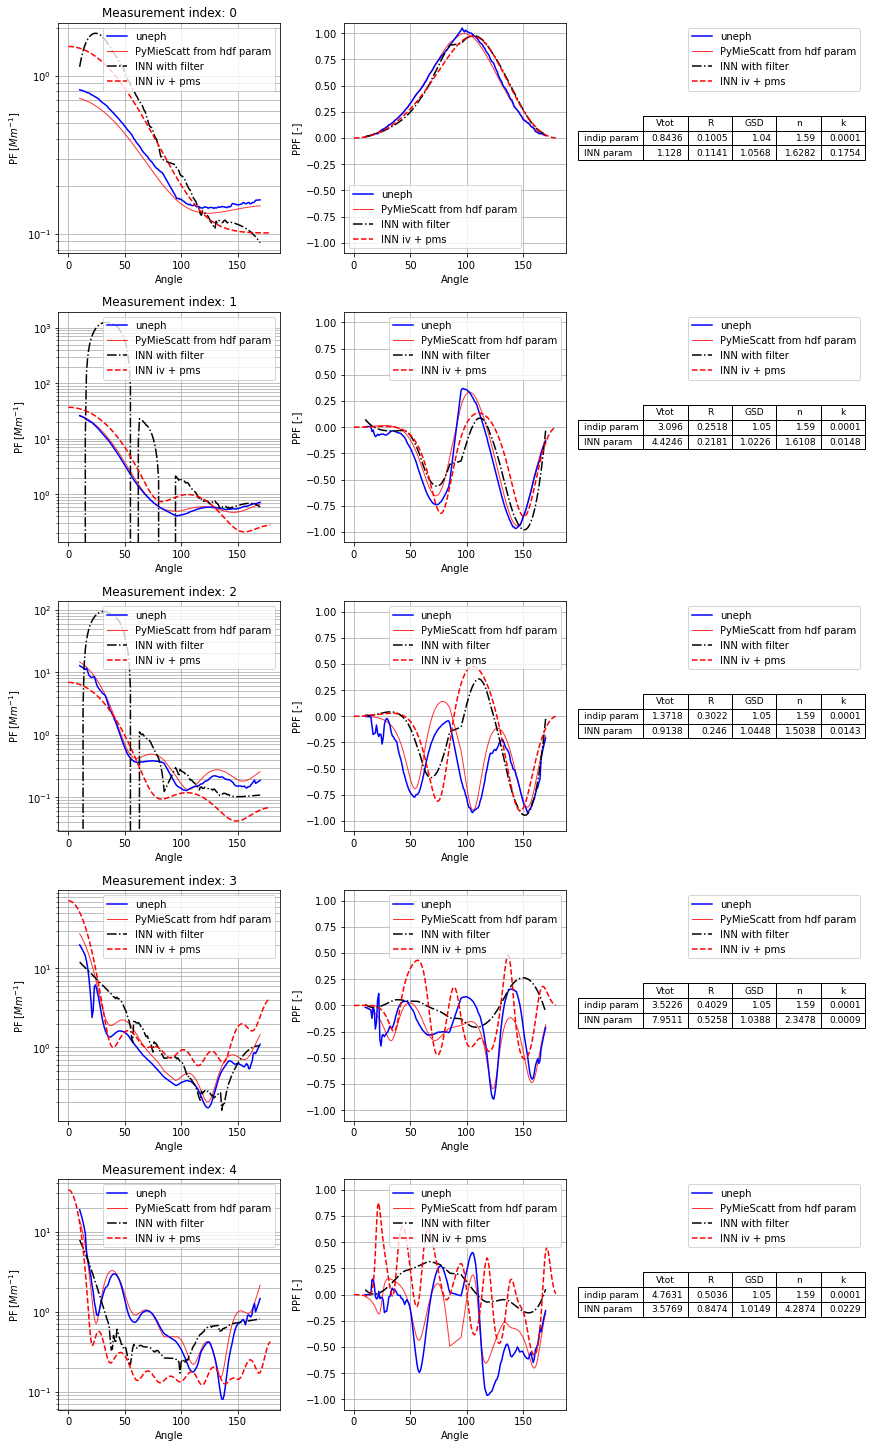

In [23]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12, 20), constrained_layout=True)

idx = 0

for index in np.arange(0, 5):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[F11_list].loc[index].values, 53, 3),ls='-.', c= 'k', label = 'INN with filter')
    meas_pred_plot, = axs[idx, 1].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[PPF_list].loc[index].values, 53, 3),ls='-.', c= 'k', label = 'INN with filter')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')
    
    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot, pms_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
    
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_PSL_filtered.jpg')

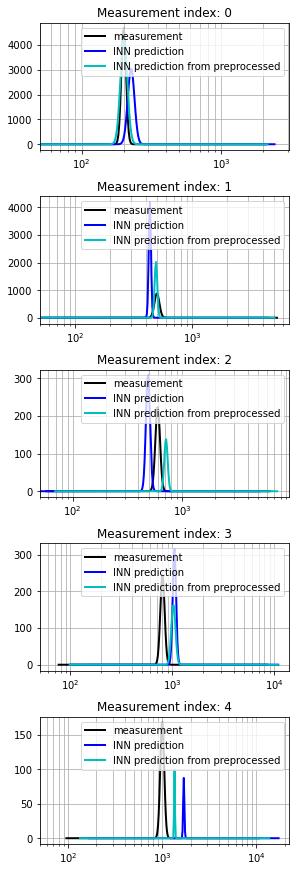

In [24]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(4, 12), constrained_layout=True)


for idx, row in uneph_dvar_plot[0:5].iterrows():
    
    axs[idx].set_title('Measurement index: '+str(idx))
    
    # measurements
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]
    axs[idx].plot(D_array, lognormal(D_array, DmedianN, row['GSD'], Ntot), c='k', ls='-', lw=2, label='measurement')

    # predictions
    DmedianV_pred = uneph_dvar_pred_iv_plot['RmedianV'].iloc[idx]*2  # [um]
    lowerD_pred = DmedianV_pred / uneph_dvar_pred_iv_plot['GSD'].iloc[idx] / nstd
    upperD_pred = DmedianV_pred * uneph_dvar_pred_iv_plot['GSD'].iloc[idx] * nstd
    D_array_pred = np.logspace(np.log10(lowerD_pred*1e3),np.log10(upperD_pred*1e3), 301) # nm
    DmedianN_pred = (np.exp(np.log(uneph_dvar_pred_iv_plot['RmedianV'].iloc[idx]*2) - (3*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[idx])**2))) *1e3   # [nm]
    Ntot_pred = 6 / np.pi * uneph_dvar_pred_iv_plot['Vtot'].iloc[idx]*1e9 / (np.exp((3*np.log(DmedianN_pred)) + (4.5*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[idx])**2))) # [cm^-3]
    axs[idx].plot(D_array_pred, lognormal(D_array_pred, DmedianN_pred, uneph_dvar_pred_iv_plot['GSD'].iloc[idx], Ntot_pred), c='b', ls='-', lw=2, label='INN prediction')
    
    # predictions preprocessed data
    DmedianV_pred_prepro = dvar_meas_preprocessed_pred_iv_plot['RmedianV'].iloc[idx]*2  # [um]
    lowerD_pred_prepro = DmedianV_pred_prepro / dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx] / nstd
    upperD_pred_prepro = DmedianV_pred_prepro * dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx] * nstd
    D_array_pred_prepro = np.logspace(np.log10(lowerD_pred_prepro*1e3),np.log10(upperD_pred_prepro*1e3), 301) # nm
    DmedianN_pred_prepro = (np.exp(np.log(dvar_meas_preprocessed_pred_iv_plot['RmedianV'].iloc[idx]*2) - (3*np.log(dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx])**2))) *1e3   # [nm]
    Ntot_pred_prepro = 6 / np.pi * dvar_meas_preprocessed_pred_iv_plot['Vtot'].iloc[idx]*1e9 / (np.exp((3*np.log(DmedianN_pred_prepro)) + (4.5*np.log(dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx])**2))) # [cm^-3]
    axs[idx].plot(D_array_pred_prepro, lognormal(D_array_pred_prepro, DmedianN_pred_prepro, dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx], Ntot_pred_prepro), c='c', ls='-', lw=2, label='INN prediction from preprocessed')

    
    
 
    axs[idx].set_xscale('log')
    axs[idx].grid(which='both')
    axs[idx].set_xlim(50, )
    axs[idx].legend()
fig.savefig(f'{plot_dir}/size_distrib_predi_PSL.jpg')


#### NIGROSINE

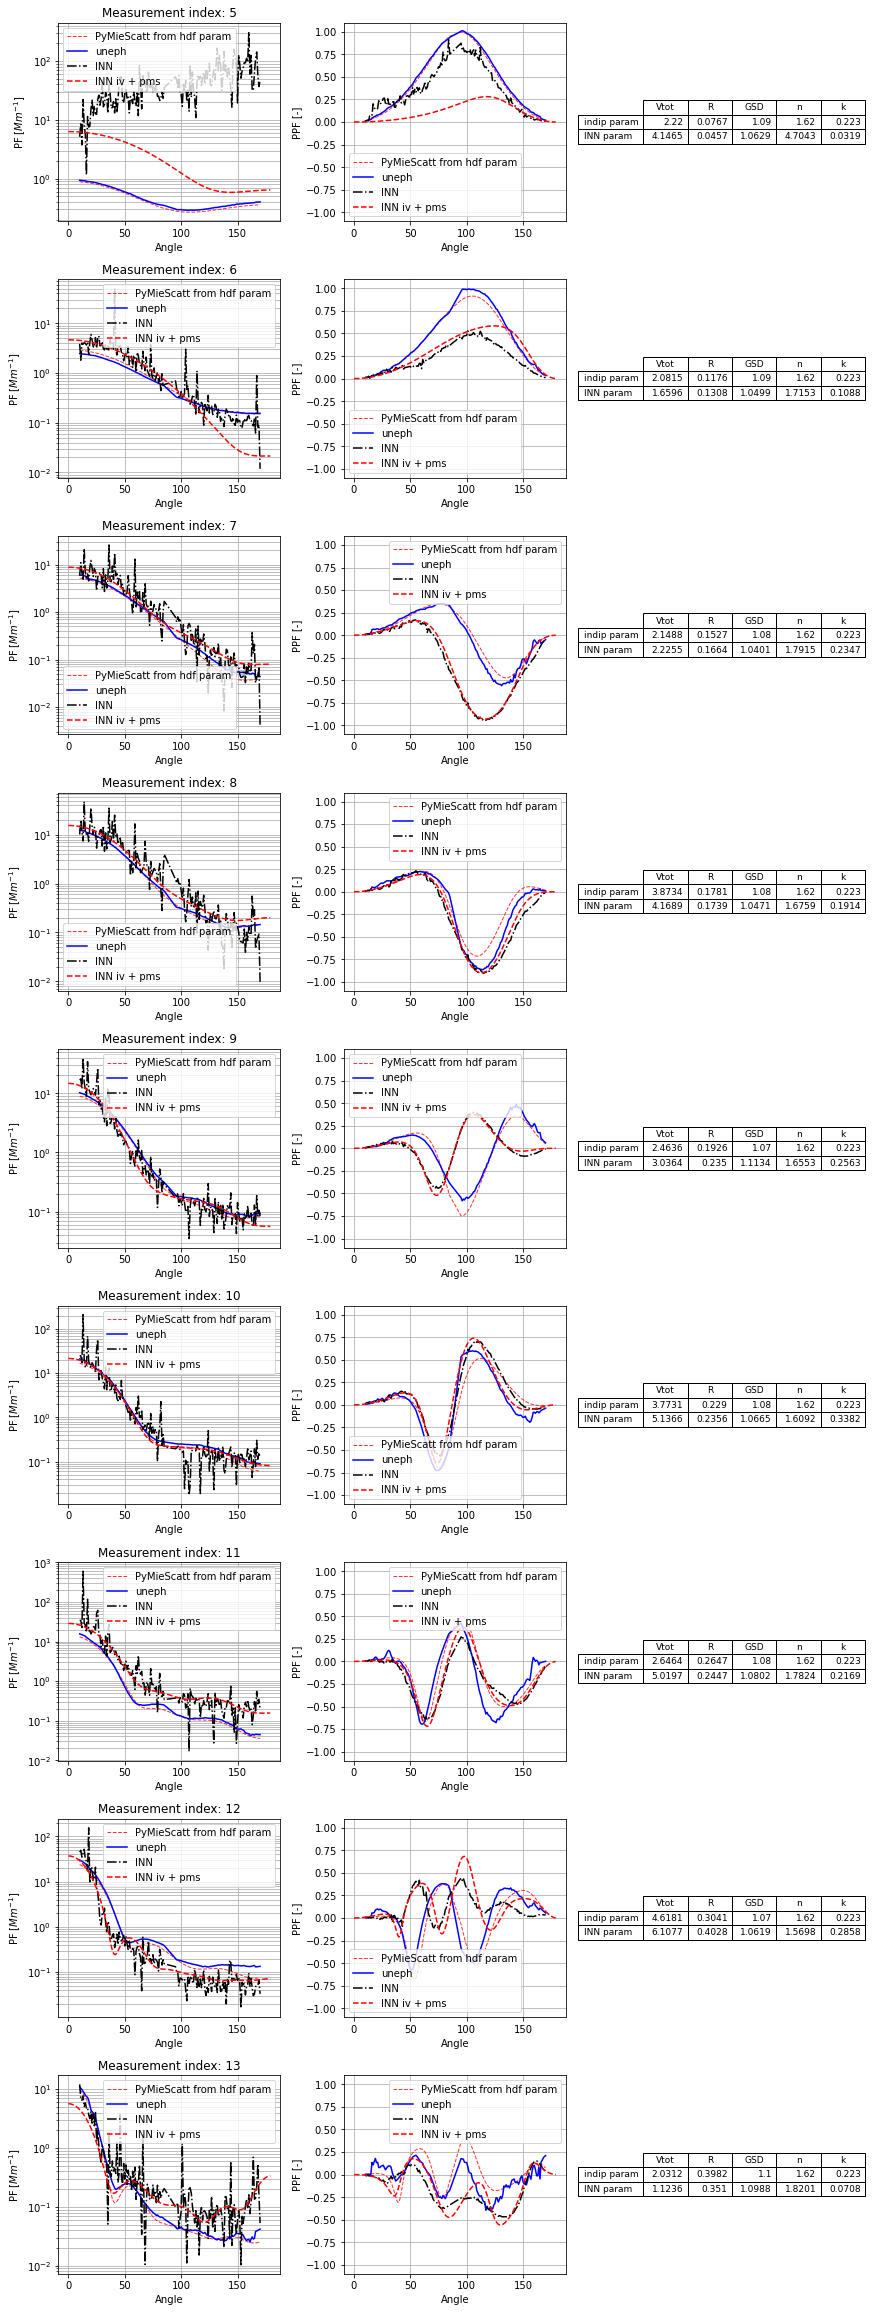

In [25]:
fig, axs = plt.subplots(ncols=3, nrows=9, figsize=(12, 32), constrained_layout=True)

idx = 0
for index in np.arange(5, 14):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    meas_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')

    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in [axs[idx, 0], axs[idx, 1]]:
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_plot, meas_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
        
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_NGR.jpg')

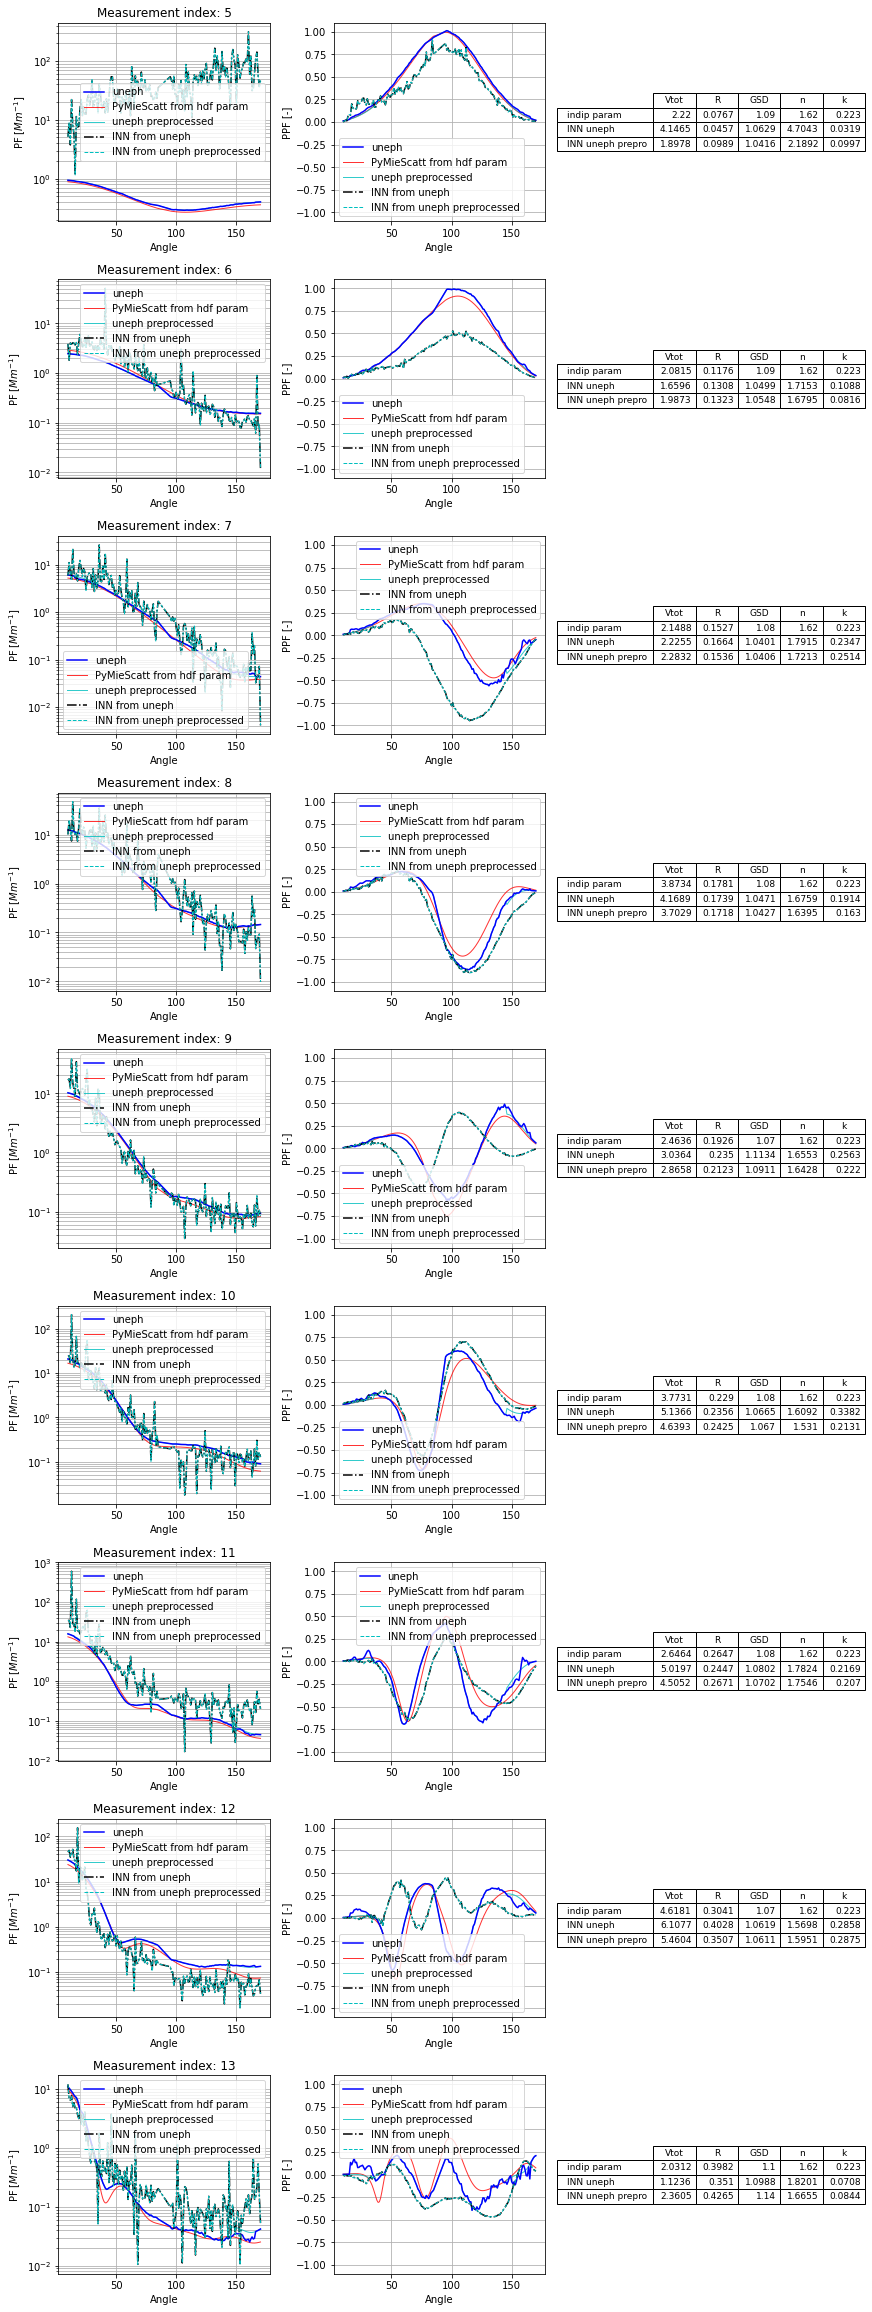

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=9, figsize=(12, 32), constrained_layout=True)

idx = 0

for index in np.arange(5, 14):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='-', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_prepro_plot, = axs[idx, 0].plot(theta, qoi_meas_preprocessed_plot[F11_list].loc[index]/4/np.pi, ls='-', lw='1', c='c', alpha=0.8, label='uneph preprocessed')
    meas_prepro_plot, = axs[idx, 1].plot(theta, qoi_meas_preprocessed_plot[PPF_list].loc[index], ls='-', lw='1', c='c', alpha=0.8, label='uneph preprocessed')
    
    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls='-.', c= 'k', label = 'INN from uneph')
    meas_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls='-.', c= 'k', label = 'INN from uneph')
    
  # pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
  #  pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')
    
    meas_prepro_pred_plot, = axs[idx, 0].plot(theta, uneph_qoi_pred_fw_plot[F11_list].loc[index].values,ls = '--',lw='1',c= 'c', label = 'INN from uneph preprocessed')
    meas_prepro_pred_plot, = axs[idx, 1].plot(theta, uneph_qoi_pred_fw_plot[PPF_list].loc[index].values,ls = '--',lw='1',c= 'c', label = 'INN from uneph preprocessed')
    
    
    
    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.grid(which='both')
    
   # axs[idx,0].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, pms_pred_qoi_plot,meas_prepro_pred_plot])
   # axs[idx,1].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, pms_pred_qoi_plot,meas_prepro_pred_plot])
    axs[idx,0].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, meas_prepro_pred_plot])
    axs[idx,1].legend(handles=[meas_plot, pms_plot, meas_prepro_plot, meas_pred_plot, meas_prepro_pred_plot])

    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model2_param = dvar_meas_preprocessed_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN uneph', 'INN uneph prepro']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param, model2_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_NGR_preprocessed.jpg')

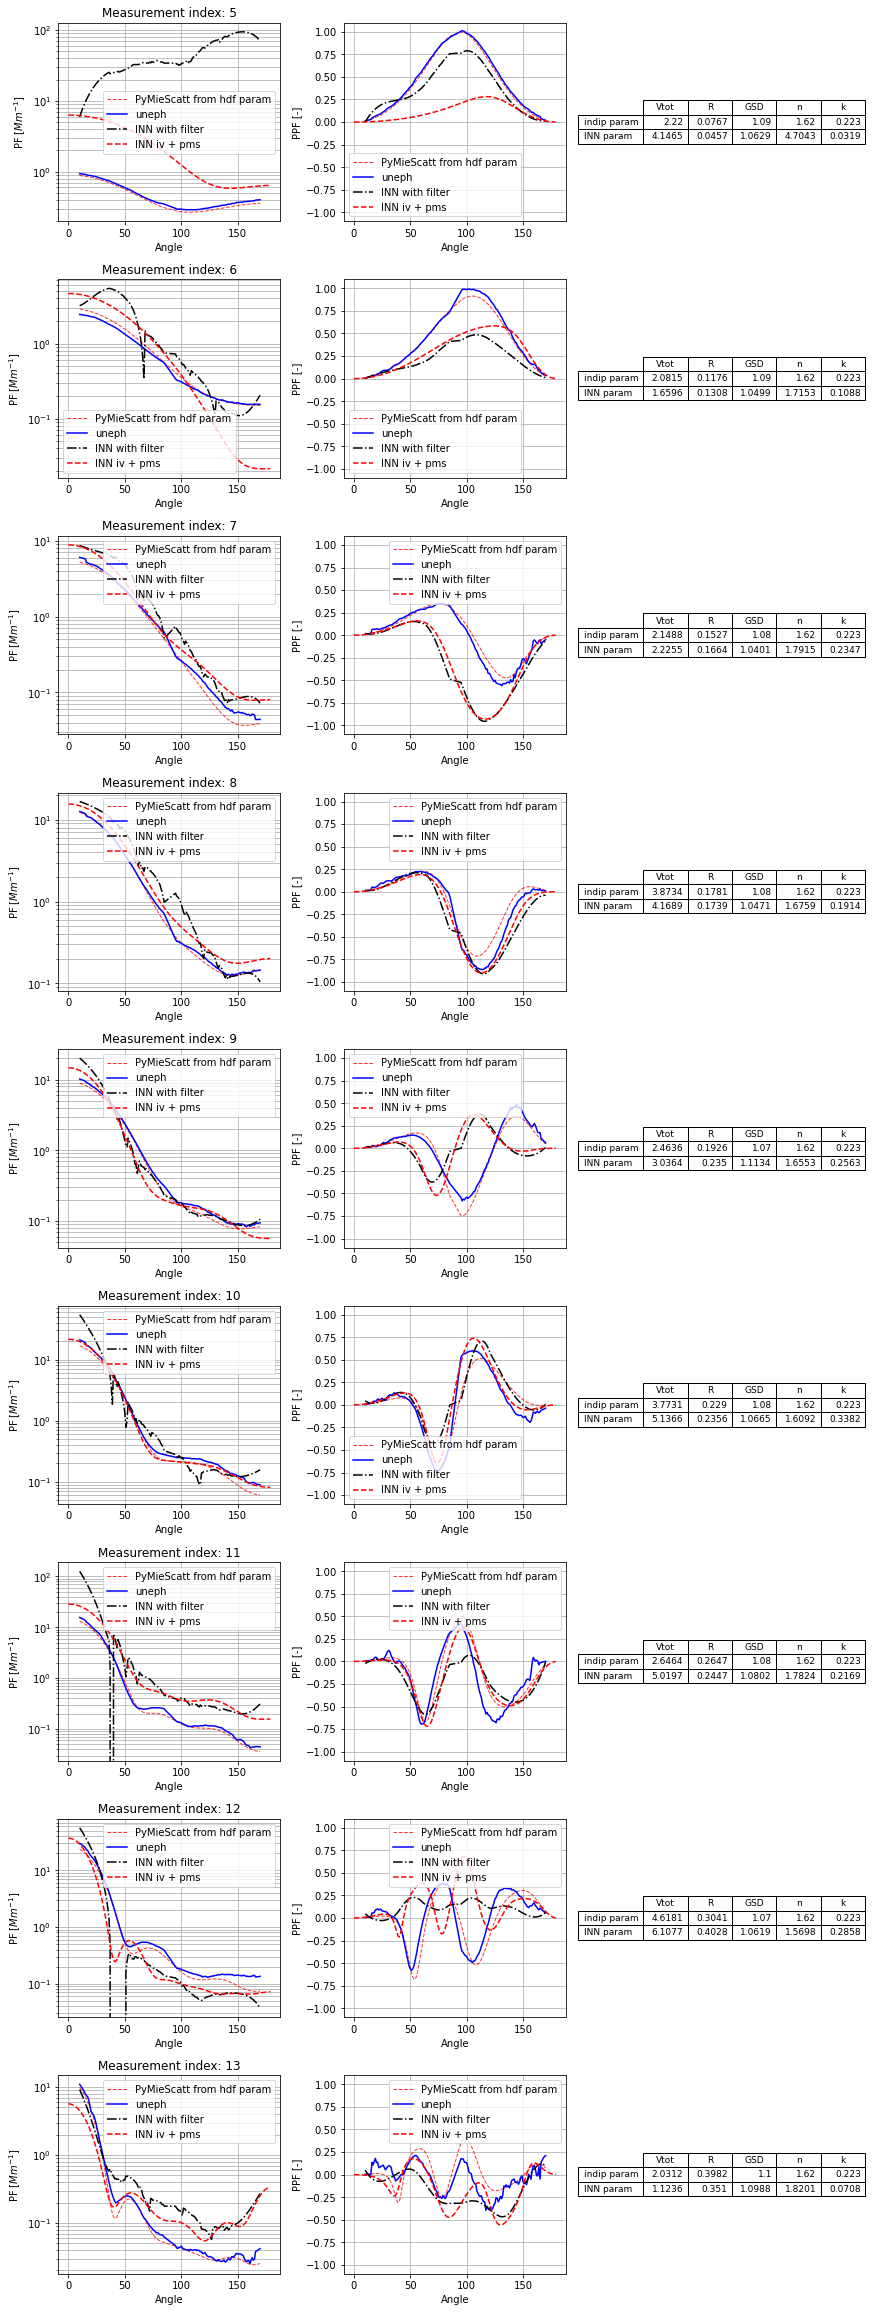

In [27]:
fig, axs = plt.subplots(ncols=3, nrows=9, figsize=(12, 32), constrained_layout=True)

idx = 0
for index in np.arange(5, 14):
    axs[idx, 0].set_title('Measurement index: '+str(index))

    pms_plot, = axs[idx, 0].plot(theta, pms_qoi_plot[F11_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_plot, = axs[idx, 1].plot(theta, pms_qoi_plot[PPF_list].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_plot, = axs[idx, 0].plot(theta, uneph_qoi_plot[F11_list].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_plot, = axs[idx, 1].plot(theta, uneph_qoi_plot[PPF_list].loc[index].values, c= 'b', label = 'uneph')
    
    meas_pred_plot, = axs[idx, 0].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[F11_list].loc[index].values, 53, 3), ls='-.', c= 'k', label = 'INN with filter')
    meas_pred_plot, = axs[idx, 1].plot(theta, signal.savgol_filter(uneph_qoi_pred_fw_plot[PPF_list].loc[index].values, 53, 3), ls='-.', c= 'k', label = 'INN with filter')
    
    pms_pred_qoi_plot, = axs[idx, 0].plot(angles, pms_pred_qoi.iloc[index, :180], ls='--', c='r', label='INN iv + pms')
    pms_pred_qoi_plot, = axs[idx, 1].plot(angles, pms_pred_qoi.iloc[index, 180:], ls='--', c='r', label='INN iv + pms')

    axs[idx,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[idx,1].set_ylabel('PPF [-]')
    axs[idx,1].set_ylim(-1.1, 1.1)
    axs[idx,0].set_yscale('log')
    for ax in [axs[idx, 0], axs[idx, 1]]:
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_plot, meas_plot, meas_pred_plot, pms_pred_qoi_plot])
        ax.grid(which='both')
        
    # table
    indip_param = uneph_dvar_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)
    model1_param = uneph_dvar_pred_iv_plot.loc[index].apply('{:,.4f}'.format).values.astype(np.float64)

    col_labels=['Vtot','R','GSD','n', 'k']
    row_labels=['indip param', 'INN param']
    
    # the rectangle is where I want to place the table
    axs[idx, 2].axis('off')
    axs[idx, 2].table(cellText=[indip_param, model1_param],
                  colWidths = [0.2]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center', fontsize=20)
    idx += 1
fig.savefig(f'{plot_dir}/PF_PPF_predi_NGR_filtered.jpg')

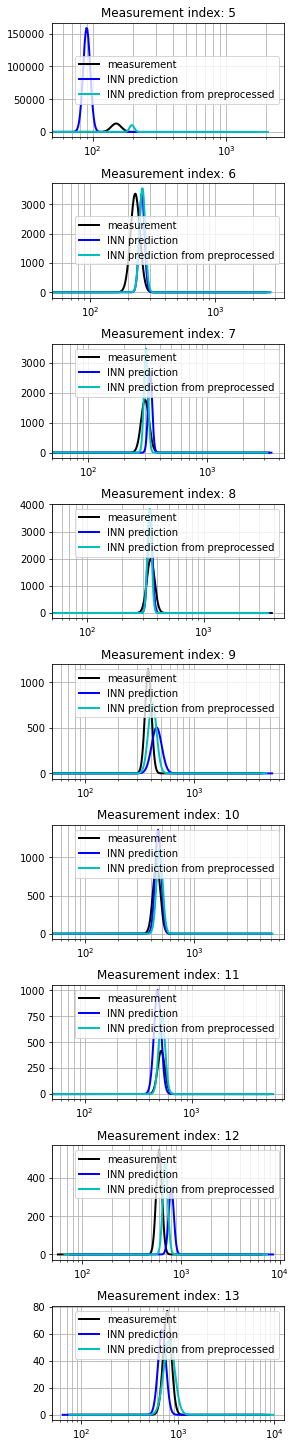

In [28]:
fig, axs = plt.subplots(ncols=1, nrows=9, figsize=(4, 20), constrained_layout=True)

idx1 = 0

for idx, row in uneph_dvar_plot[5:].iterrows():
    
    axs[idx1].set_title('Measurement index: '+str(idx))
    
    # measurements
    DmedianV = row['RmedianV']*2  # [um]
    lowerD = DmedianV / row['GSD'] / nstd
    upperD = DmedianV * row['GSD'] * nstd
    D_array = np.logspace(np.log10(lowerD*1e3),np.log10(upperD*1e3), 301) # nm
    DmedianN = (np.exp(np.log(row['RmedianV']*2) - (3*np.log(row['GSD'])**2))) *1e3   # [nm]
    Ntot = 6 / np.pi * row['Vtot']*1e9 / (np.exp((3*np.log(DmedianN)) + (4.5*np.log(row['GSD'])**2))) # [cm^-3]
    axs[idx1].plot(D_array, lognormal(D_array, DmedianN, row['GSD'], Ntot), c='k', ls='-', lw=2, label='measurement')

    # predictions
    DmedianV_pred = uneph_dvar_pred_iv_plot['RmedianV'].iloc[idx]*2  # [um]
    lowerD_pred = DmedianV_pred / uneph_dvar_pred_iv_plot['GSD'].iloc[idx] / nstd
    upperD_pred = DmedianV_pred * uneph_dvar_pred_iv_plot['GSD'].iloc[idx] * nstd
    D_array_pred = np.logspace(np.log10(lowerD_pred*1e3),np.log10(upperD_pred*1e3), 301) # nm
    DmedianN_pred = (np.exp(np.log(uneph_dvar_pred_iv_plot['RmedianV'].iloc[idx]*2) - (3*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[idx])**2))) *1e3   # [nm]
    Ntot_pred = 6 / np.pi * uneph_dvar_pred_iv_plot['Vtot'].iloc[idx]*1e9 / (np.exp((3*np.log(DmedianN_pred)) + (4.5*np.log(uneph_dvar_pred_iv_plot['GSD'].iloc[idx])**2))) # [cm^-3]
    axs[idx1].plot(D_array_pred, lognormal(D_array_pred, DmedianN_pred, uneph_dvar_pred_iv_plot['GSD'].iloc[idx], Ntot_pred), c='b', ls='-', lw=2, label='INN prediction')
    
    # predictions preprocessed data
    DmedianV_pred_prepro = dvar_meas_preprocessed_pred_iv_plot['RmedianV'].iloc[idx]*2  # [um]
    lowerD_pred_prepro = DmedianV_pred_prepro / dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx] / nstd
    upperD_pred_prepro = DmedianV_pred_prepro * dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx] * nstd
    D_array_pred_prepro = np.logspace(np.log10(lowerD_pred_prepro*1e3),np.log10(upperD_pred_prepro*1e3), 301) # nm
    DmedianN_pred_prepro = (np.exp(np.log(dvar_meas_preprocessed_pred_iv_plot['RmedianV'].iloc[idx]*2) - (3*np.log(dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx])**2))) *1e3   # [nm]
    Ntot_pred_prepro = 6 / np.pi * dvar_meas_preprocessed_pred_iv_plot['Vtot'].iloc[idx]*1e9 / (np.exp((3*np.log(DmedianN_pred_prepro)) + (4.5*np.log(dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx])**2))) # [cm^-3]
    axs[idx1].plot(D_array_pred_prepro, lognormal(D_array_pred_prepro, DmedianN_pred_prepro, dvar_meas_preprocessed_pred_iv_plot['GSD'].iloc[idx], Ntot_pred_prepro), c='c', ls='-', lw=2, label='INN prediction from preprocessed')

    
    
 
    axs[idx1].set_xscale('log')
    axs[idx1].grid(which='both')
    axs[idx1].set_xlim(50, )
    axs[idx1].legend()
    idx1 = idx1+1
fig.savefig(f'{plot_dir}/size_distrib_predi_NIGR.jpg')


### Metrics

#### 1. Mean absolute error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

In [29]:
MAE_all_dvar = []
print('MAE dvar:')
for col in uneph_dvar_plot.keys():
    MAE = mean_absolute_error(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col])
    MAE_all_dvar.append(MAE)
    print('%s : \t %.3f' %(col, MAE))
MAE_all_dvar = np.array(MAE_all_dvar)

print('\n')

MAE_qoi = []
for col in uneph_qoi.keys():
    MAE = mean_absolute_error(uneph_qoi[col], uneph_qoi_pred_fw[col])
    MAE_qoi.append(MAE)
MAE_qoi = np.array(MAE_qoi)
MAE_qoi = pd.DataFrame([MAE_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['MAE_qoi'])
print(MAE_qoi.apply(pd.DataFrame.describe, axis = 1))

MAE dvar:
Vtot : 	 1.222
RmedianV : 	 0.061
GSD : 	 0.022
n : 	 0.533
k : 	 0.068


         count      mean       std       min       25%      50%       75%  \
MAE_qoi  304.0  0.593448  0.433111  0.008279  0.217147  0.40895  0.961235   

              max  
MAE_qoi  2.018586  


#### 2. Mean absolute percentage error

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [30]:
MAPE_all_dvar = []
print('MAPE dvar:')
for col in uneph_dvar_plot.keys():
    MAPE = mean_absolute_percentage_error(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col])
    MAPE_all_dvar.append(MAPE)
    print('%s : \t %.3f' %(col, MAPE))
MAPE_all_dvar = np.array(MAPE_all_dvar)

print('\n')

MAPE_qoi = []
for col in uneph_qoi.keys():
    MAPE = mean_absolute_percentage_error(uneph_qoi[col], uneph_qoi_pred_fw[col])
    MAPE_qoi.append(MAPE)
MAPE_qoi = np.array(MAPE_qoi)
MAPE_qoi = pd.DataFrame([MAPE_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['MAPE_qoi'])
print(MAPE_qoi.apply(pd.DataFrame.describe, axis = 1))

MAPE dvar:
Vtot : 	 0.432
RmedianV : 	 0.203
GSD : 	 0.020
n : 	 0.332
k : 	 162.945


          count      mean        std       min       25%      50%       75%  \
MAPE_qoi  304.0  5.485882  37.923819  0.487504  0.838618  1.37698  2.084516   

                 max  
MAPE_qoi  628.341941  


#### 3. Root mean squared error

RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 

In [31]:
RMSE_dvar = []
print('RMSE dvar:')
for col in uneph_dvar_plot.keys():
    RMSE = np.sqrt(mean_squared_error(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col]))
    RMSE_dvar.append(RMSE)
    print('%s : \t %.3f' %(col, RMSE))
RMSE_dvar = pd.DataFrame(RMSE_dvar, index=uneph_dvar_plot.keys()).T

print('\n')

RMSE_qoi = []
for col in uneph_qoi.keys():
    RMSE = np.sqrt(abs(mean_squared_error(uneph_qoi[col], uneph_qoi_pred_fw[col])))
    RMSE_qoi.append(RMSE)
RMSE_qoi = np.array(RMSE_qoi)
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['RMSE_qoi'])
print(RMSE_qoi.apply(pd.DataFrame.describe, axis = 1))

RMSE dvar:
Vtot : 	 1.646
RmedianV : 	 0.105
GSD : 	 0.026
n : 	 1.118
k : 	 0.094


          count      mean       std       min       25%      50%       75%  \
RMSE_qoi  304.0  0.883469  0.667604  0.010378  0.265376  0.54915  1.505417   

               max  
RMSE_qoi  3.004647  


#### 4. Explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [32]:
EVS_dvar = []
print('EVS dvar:')
for col in uneph_dvar_plot.keys():
    EVS = explained_variance_score(uneph_dvar_plot[col], uneph_dvar_pred_iv_plot[col])
    EVS_dvar.append(EVS)
    print('%s : \t %.3f' %(col, EVS))
EVS_dvar = pd.DataFrame(EVS_dvar, index=uneph_dvar_plot.keys()).T

print('\n')

EVS_qoi = []
for col in uneph_qoi.keys():
    EVS = explained_variance_score(uneph_qoi[col], uneph_qoi_pred_fw[col])
    EVS_qoi.append(EVS)
EVS_qoi = np.array(EVS_qoi)
EVS_qoi = pd.DataFrame([EVS_qoi], columns = np.concatenate([F11_list, PPF_list]), index=['EVS_qoi'])
print(EVS_qoi.apply(pd.DataFrame.describe, axis = 1))

EVS dvar:
Vtot : 	 -0.636
RmedianV : 	 0.322
GSD : 	 -0.570
n : 	 -4772.969
k : 	 0.225


         count      mean       std       min       25%       50%       75%  \
EVS_qoi  304.0 -1.385519  2.733815 -20.36888 -2.590905 -0.136649  0.422611   

              max  
EVS_qoi  0.867769  


In [33]:
EVS_qoi.sort_values(by=EVS_qoi.index[0], axis = 1, ascending=True).iloc[0, :10]

F11_107   -20.368880
PPF_11    -20.311277
F11_129   -10.284643
F11_114    -8.442982
F11_128    -7.923222
F11_104    -7.791401
F11_108    -7.745695
F11_138    -7.678284
F11_100    -7.594171
F11_35     -7.368229
Name: EVS_qoi, dtype: float64

In [34]:
EVS_qoi.apply(pd.DataFrame.describe, axis=1)

count      mean       std       min       25%       50%       75%  \
EVS_qoi  304.0 -1.385519  2.733815 -20.36888 -2.590905 -0.136649  0.422611   

              max  
EVS_qoi  0.867769

In [35]:
#Store the results

In [36]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv5/models/plots/measurements_new'

In [37]:
uneph_dvar_pred_iv_plot.to_csv(f'{plot_dir}/dvar_meas_pred.csv') 
dvar_meas_preprocessed_pred_iv_plot.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv') 




In [38]:
uneph_qoi_pred_fw_plot.to_csv(f'{plot_dir}/qoi_meas_pred.csv') 
qoi_meas_preprocessed_pred_fw_plot.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv') 
pms_pred_qoi_preprocessed.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred_pms.csv') 
pms_pred_qoi.to_csv(f'{plot_dir}/qoi_meas_pred_pms.csv') 

In [22]:
# Relative error 

In [23]:
def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error

In [24]:
relerr1 = rel_error(uneph_dvar_plot,uneph_dvar_pred_iv_plot)
relerr2 = rel_error(uneph_dvar_plot,dvar_meas_preprocessed_pred_iv_plot)


In [25]:
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4

Vtot  RmedianV   GSD      n         k
meas_vs_pred               52.13     28.87  1.83  45.29  45560.06
meas_vs_preprocessed_pred  36.28     16.76  1.86  27.82  43616.02

In [26]:
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

Vtot  RmedianV   GSD      n      k
meas_vs_pred               38.25     15.52  2.12  26.51  35.79
meas_vs_preprocessed_pred  19.30      9.45  2.59   7.31  29.06

In [27]:
relerr5 = rel_error(uneph_qoi_plot, uneph_qoi_pred_fw_plot)
relerr6 = rel_error(uneph_qoi_plot, qoi_meas_preprocessed_pred_fw_plot)


In [28]:
rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

F11     PPF
meas_vs_meas_pred               127.19  372.18
meas_vs_meas_preprocessed_pred   94.12  180.36

In [29]:
rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13

F11      PPF
meas_vs_meas_pred               176.43  1048.13
meas_vs_meas_preprocessed_pred   84.48  1347.24

In [30]:
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')

In [31]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv5/models/plots/measurements_new'